# Projeto 1 - TAG UNB
## Análise de Rede Social - Facebook

**Integrantes:**
- [Gustavo Choueiri] - [232014010]
- [Giovanni Daldegan] - [232002520]

**Objetivo:** Analisar estruturas de redes sociais, utilizando as métricas de grafos, para avaliar influências e potenciais de usuários.

### Estrutura do Projeto:
1. **Coleta de Dados**: Extração de 2000 nós aleatórios do Facebook
2. **Construção do Grafo**: Representação usando NetworkX
3. **Detecção de Comunidades**: Algoritmo de Louvain
4. **Medidas de Centralidade**: Grau, Intermediação, Proximidade e Autovetor
5. **Visualizações**: Comunidades e medidas de centralidade
6. **Relatório de Análise**: Interpretações e recomendações

---

## 1. Importação de Bibliotecas e Configurações

In [12]:
import networkx as nx
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import os
import warnings
warnings.filterwarnings('ignore')

# Configurações para visualização
plt.style.use('default')
sns.set_palette("husl")

## 2. Coleta de Dados e construção do grafo

In [13]:
def coletar_dados_facebook(diretorio_dados="dados_facebook", num_nos=2000):
    # Lista todos os arquivos de arestas disponíveis
    arquivos_edges = [f for f in os.listdir(diretorio_dados) if f.endswith('.edges')]
    
    # Coleta todos os nós únicos de todos os arquivos
    todos_nos = set()
    todas_arestas = []
    
    for arquivo in arquivos_edges:
        caminho_arquivo = os.path.join(diretorio_dados, arquivo)
        
        with open(caminho_arquivo, 'r') as f:
            for linha in f:
                linha = linha.strip()
                if linha:
                    # Cada linha contém dois IDs de nós conectados
                    nos = linha.split()
                    if len(nos) == 2:
                        n1, n2 = int(nos[0]), int(nos[1])
                        todos_nos.add(n1)
                        todos_nos.add(n2)
                        todas_arestas.append((n1, n2))
    
    print(f"Total de nós únicos encontrados: {len(todos_nos)}")
    print(f"Total de arestas encontradas: {len(todas_arestas)}")
    
    # Define seed para reprodutibilidade
    random.seed(42)
    
    # Seleciona 2000 nós aleatórios
    nos_selecionados = set(random.sample(list(todos_nos), min(num_nos, len(todos_nos))))
    print(f"Nós selecionados aleatoriamente: {len(nos_selecionados)}")
    
    # Filtra arestas que conectam apenas os nós selecionados
    arestas_filtradas = []
    for n1, n2 in todas_arestas:
        if n1 in nos_selecionados and n2 in nos_selecionados:
            arestas_filtradas.append((n1, n2))
    
    print(f"Arestas filtradas: {len(arestas_filtradas)}")
    
    # Cria o grafo
    G = nx.Graph()
    G.add_nodes_from(nos_selecionados)
    G.add_edges_from(arestas_filtradas)
    
    print("\nGrafo criado:")
    print(f"- Número de nós: {G.number_of_nodes()}")
    print(f"- Número de arestas: {G.number_of_edges()}")
    print(f"- Densidade: {nx.density(G):.4f}")
    print(f"- Número de componentes conectados: {nx.number_connected_components(G)}")
    
    return G

In [14]:
# Executa a coleta de dados
G = coletar_dados_facebook()

Total de nós únicos encontrados: 3959
Total de arestas encontradas: 170174
Nós selecionados aleatoriamente: 2000
Arestas filtradas: 44502

Grafo criado:
- Número de nós: 2000
- Número de arestas: 22066
- Densidade: 0.0110
- Número de componentes conectados: 79


## 3. Detecção de Comunidades - Algoritmo de Louvain

In [15]:
def detectar_comunidades_louvain(G):    
    try:
        # Usa o algoritmo de Louvain do NetworkX
        comunidades = nx.community.louvain_communities(G, seed=42)
        
        # Converte para dicionário
        comunidades_dict = {}
        for i, comunidade in enumerate(comunidades):
            for no in comunidade:
                comunidades_dict[no] = i
        
        print(f"Número de comunidades detectadas: {len(comunidades)}")
        print(f"Tamanhos das 15 maiores comunidades: {str(sorted([len(c) for c in comunidades], reverse=True)[:15])[1:-1]}")
        
        return comunidades_dict, comunidades

    except Exception as e:
        print(f"A detecção de comunidades pelo método de Louvain falhou. {e}")

comunidades_dict, comunidades_list = detectar_comunidades_louvain(G)

Número de comunidades detectadas: 100
Tamanhos das 15 maiores comunidades: 264, 255, 207, 139, 129, 117, 115, 110, 84, 73, 73, 56, 50, 34, 33


## 4. Cálculo de Medidas de Centralidade

In [16]:
def calcular_medidas_centralidade(G):
    return {
        'grau' :            nx.degree_centrality(G),
        'intermediacao' :   nx.betweenness_centrality(G),
        'proximidade' :     nx.closeness_centrality(G),
        'autovetor' :       nx.eigenvector_centrality(G, max_iter=1000)
    }

def resumo_medidas_centralidade(medidas):
    for nome_medida, valores in medidas.items():
        valores_array = np.array(list(valores.values()))
        
        print(f"\n{nome_medida.upper()}:")
        print(f"  Média: {np.mean(valores_array):.4f}")
        print(f"  Mediana: {np.median(valores_array):.4f}")
        print(f"  Desvio padrão: {np.std(valores_array):.4f}")
        print(f"  Mínimo: {np.min(valores_array):.4f}")
        print(f"  Máximo: {np.max(valores_array):.4f}")
        

def encontrar_nos_mais_influentes(medidas, top_k=10):
    nos_influentes = {}
    
    for nome_medida, valores in medidas.items():
        top_nos = sorted(valores.items(), key=lambda x: x[1], reverse=True)[:top_k]
        nos_influentes[nome_medida] = top_nos
    
    return nos_influentes

medidas = calcular_medidas_centralidade(G)
resumo_medidas_centralidade(medidas)

nos_influentes = encontrar_nos_mais_influentes(medidas, top_k=10)


GRAU:
  Média: 0.0110
  Mediana: 0.0065
  Desvio padrão: 0.0123
  Mínimo: 0.0000
  Máximo: 0.0730

INTERMEDIACAO:
  Média: 0.0018
  Mediana: 0.0001
  Desvio padrão: 0.0097
  Mínimo: 0.0000
  Máximo: 0.2652

PROXIMIDADE:
  Média: 0.1433
  Mediana: 0.1594
  Desvio padrão: 0.0576
  Mínimo: 0.0000
  Máximo: 0.2417

AUTOVETOR:
  Média: 0.0055
  Mediana: 0.0000
  Desvio padrão: 0.0217
  Mínimo: 0.0000
  Máximo: 0.1221


## 5. Visualizações

1. Visualização de comunidades


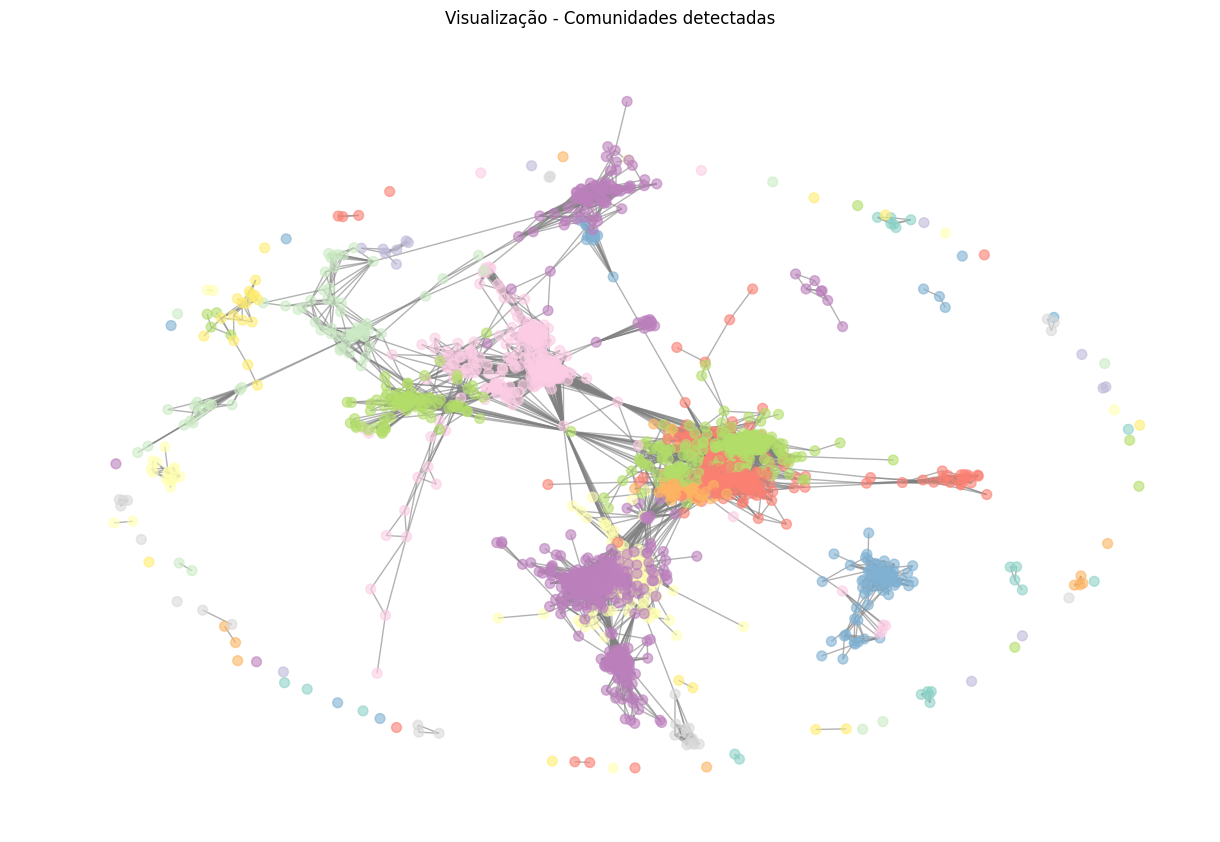

2. Visualização de medidas de centralidade
   - grau


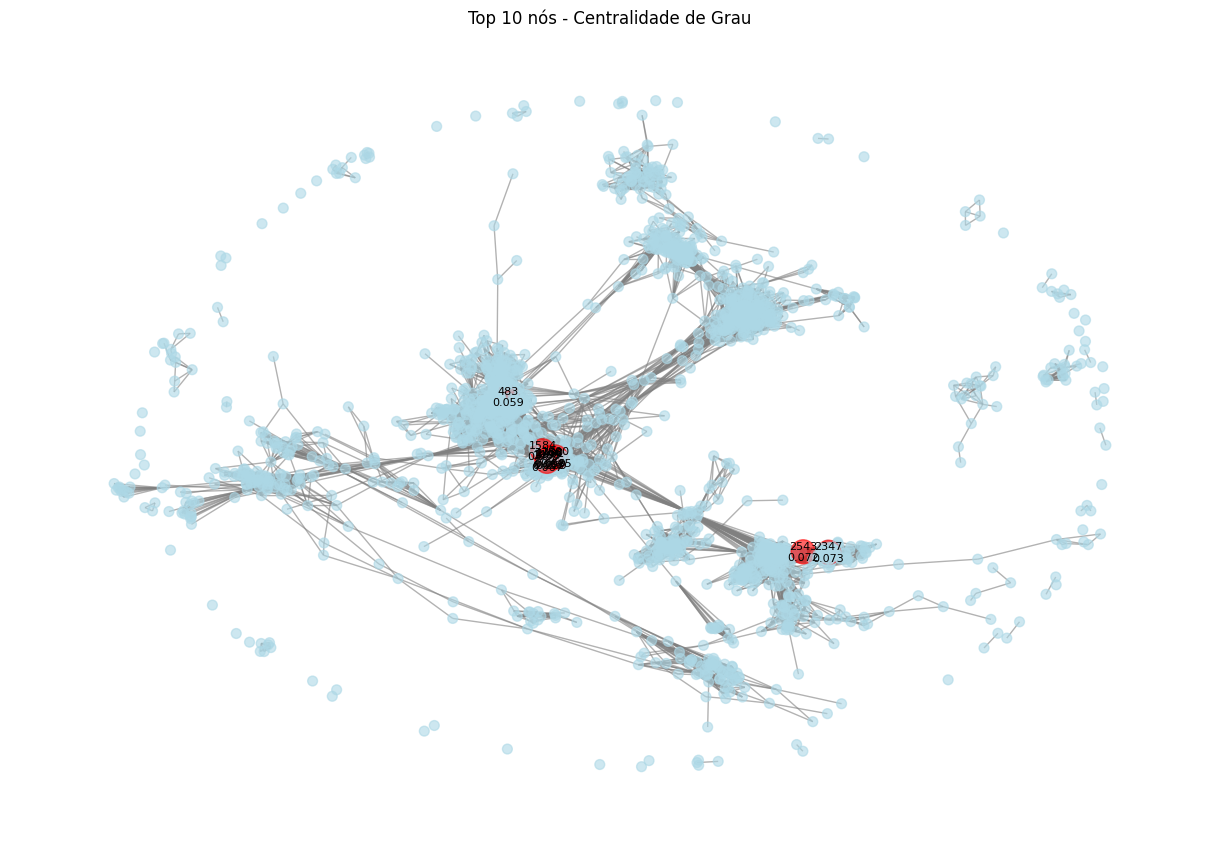

   - intermediacao


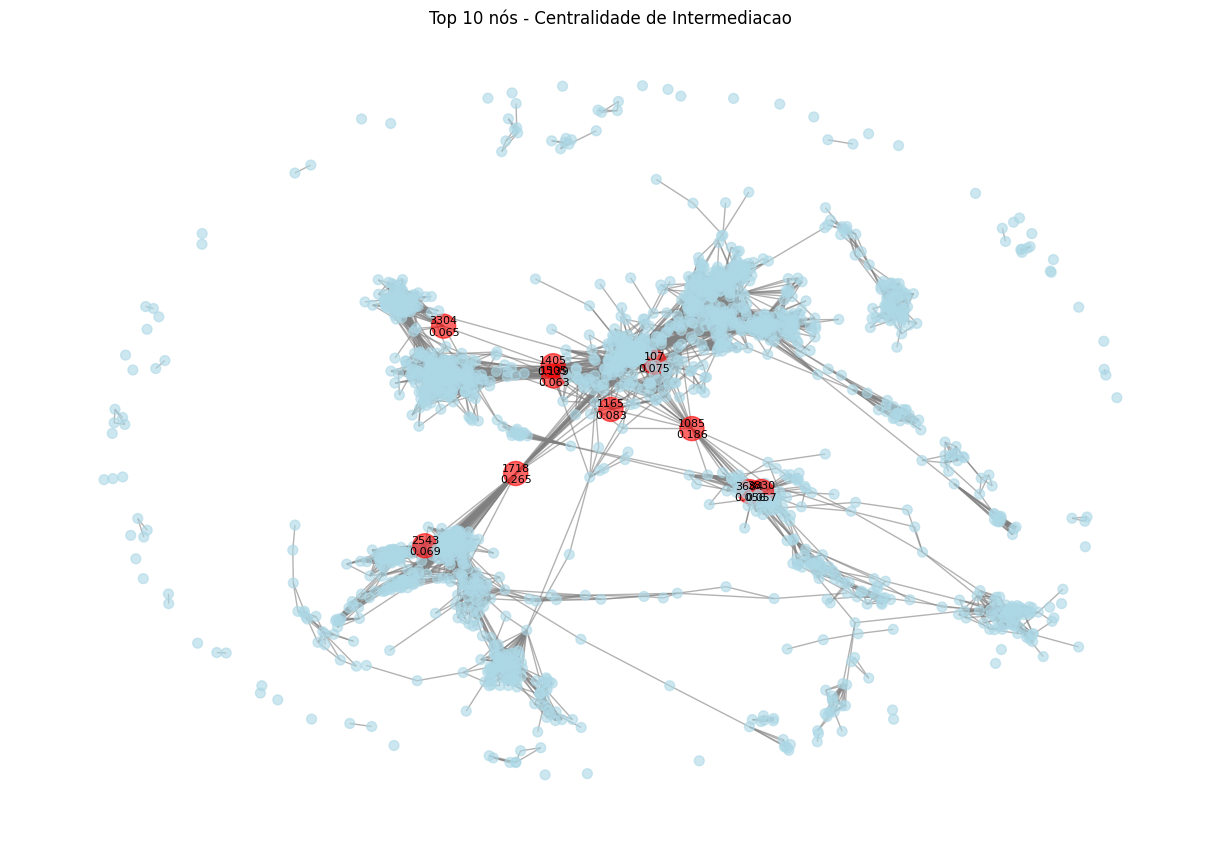

   - proximidade


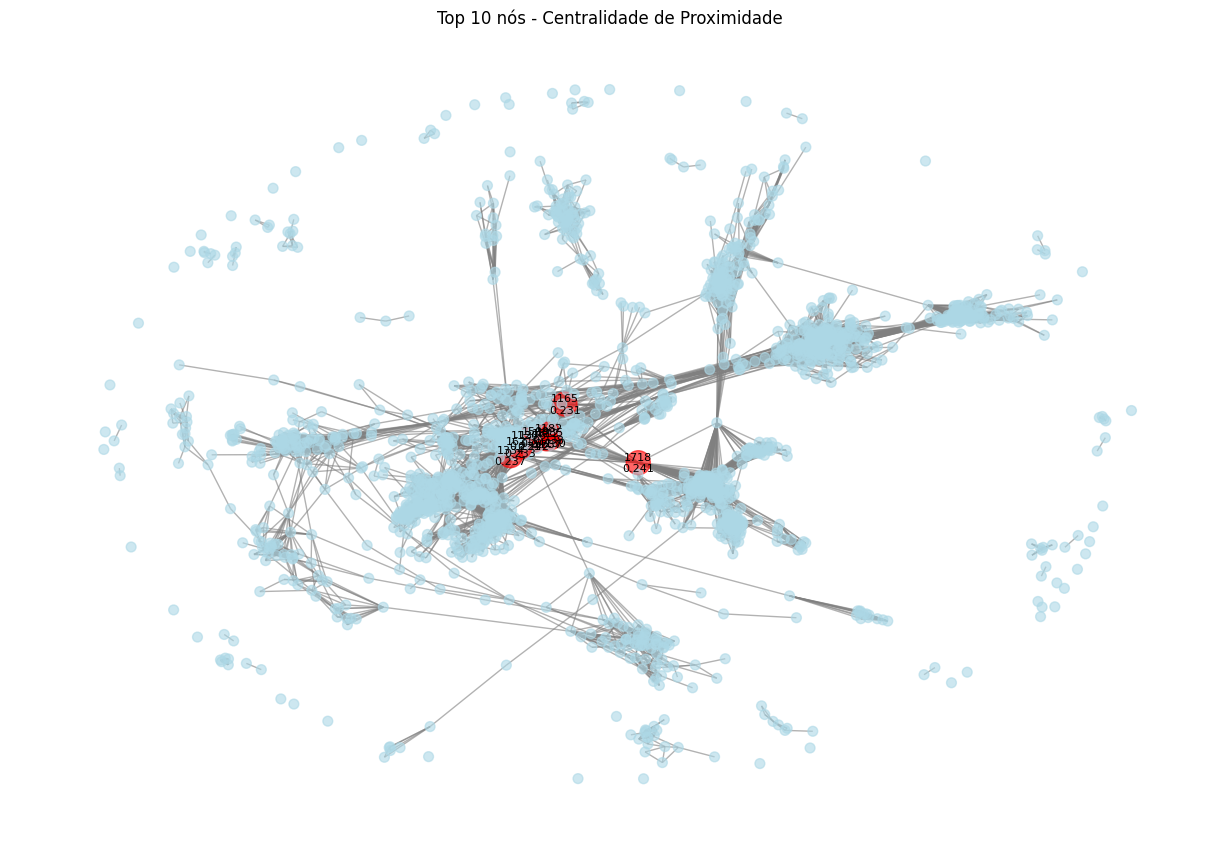

   - autovetor


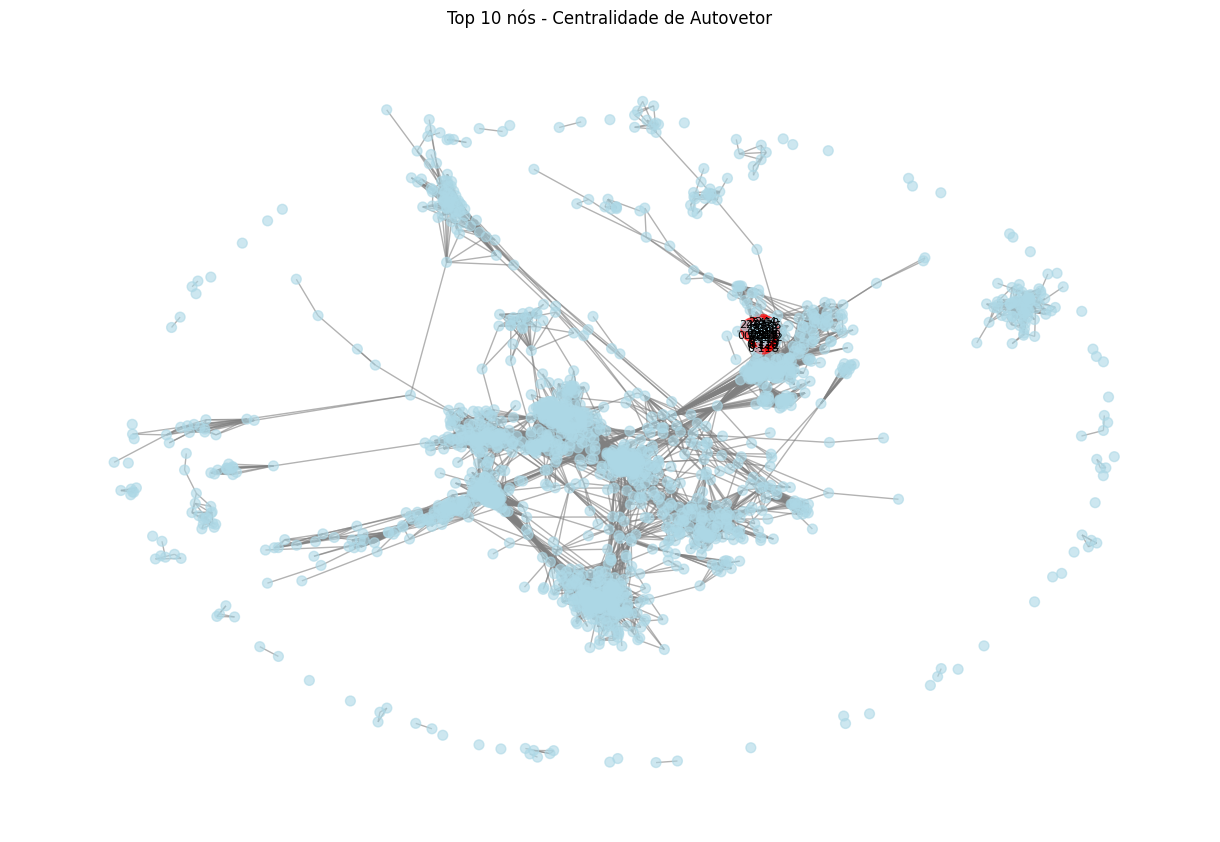

3. Visualização da correlação entre as medidas


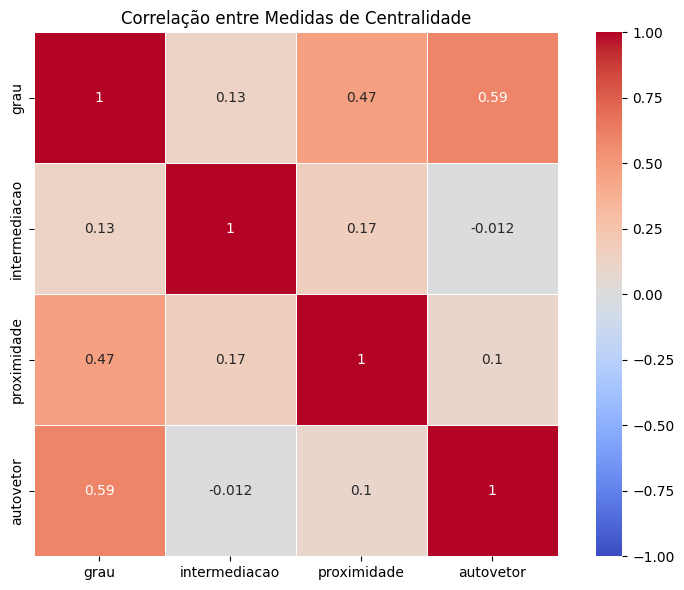

In [17]:
def visualizar_grafo_comunidades(G, comunidades_dict, titulo="Grafo com Comunidades"):
    plt.figure(figsize=(12, 8))
    
    # Define cores para as comunidades
    num_comunidades = len(set(comunidades_dict.values()))
    cores = plt.cm.Set3(np.linspace(0, 1, num_comunidades))
    
    # Mapeia cada nó para sua cor de comunidade
    cores_nos = [cores[comunidades_dict.get(no, 0)] for no in G.nodes()]
    
    # Layout do grafo
    pos = nx.spring_layout(G, k=1, iterations=50)
    
    # Desenha o grafo
    nx.draw(G, pos, 
            node_color=cores_nos,
            node_size=50,
            edge_color='gray',
            alpha=0.6,
            with_labels=False)
    
    plt.title(titulo)
    plt.axis('off')
    plt.tight_layout()
    plt.show()


def visualizar_centralidade(G, medidas, medida_nome, top_k=10):
    plt.figure(figsize=(12, 8))
    
    centralidade = medidas[medida_nome]
    
    # Encontra os top k nós
    top_nos = sorted(centralidade.items(), key=lambda x: x[1], reverse=True)[:top_k]
    top_nos_set = set([no for no, _ in top_nos])
    
    # Define cores e tamanhos dos nós
    cores_nos = []
    tamanhos_nos = []
    
    for no in G.nodes():
        if no in top_nos_set:
            cores_nos.append('red')
            tamanhos_nos.append(300)
        else:
            cores_nos.append('lightblue')
            tamanhos_nos.append(50)
    
    # Layout do grafo
    pos = nx.spring_layout(G, k=1, iterations=50)
    
    # Desenha o grafo
    nx.draw(G, pos,
            node_color=cores_nos,
            node_size=tamanhos_nos,
            edge_color='gray',
            alpha=0.6,
            with_labels=False)
    
    # Adiciona labels para os top nós
    labels = {no: f"{no}\n{centralidade[no]:.3f}" for no in top_nos_set}
    nx.draw_networkx_labels(G, pos, labels, font_size=8, font_color='black')
    
    plt.title(f"Top {top_k} nós - Centralidade de {medida_nome.title()}")
    plt.axis('off')
    plt.tight_layout()
    plt.show()


def criar_heatmap_correlacao(medidas):
    # Converte para DataFrame
    df = pd.DataFrame(medidas)
    
    # Calcula matriz de correlação
    correlacao = df.corr()
    
    # Cria o heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(correlacao, annot=True, cmap='coolwarm', center=0,
                square=True, linewidths=0.5, vmin=-1.0, vmax=1.0)
    plt.title('Correlação entre Medidas de Centralidade')
    plt.tight_layout()
    plt.show()

print("1. Visualização de comunidades")
visualizar_grafo_comunidades(G, comunidades_dict, "Visualização - Comunidades detectadas")

print("2. Visualização de medidas de centralidade")
for medida_nome in medidas.keys():
    print(f"   - {medida_nome}")
    visualizar_centralidade(G, medidas, medida_nome, top_k=10)

print("3. Visualização da correlação entre as medidas")
criar_heatmap_correlacao(medidas)

## 6. Análise geral

In [18]:
def analisar_grafo(G, comunidades_dict, comunidades_list, nos_influentes):    
    print("\nRESUMO GERAL DO GRAFO:")
    print(f"   • Número total de nós: {G.number_of_nodes()}")
    print(f"   • Número total de arestas: {G.number_of_edges()}")
    print(f"   • Densidade: {nx.density(G):.4f}")
    print(f"   • Número de comunidades: {len(comunidades_list)}")
    
    print(f"\nANÁLISE DE COMUNIDADES:")
    tamanhos_comunidades = [len(comunidade) for comunidade in comunidades_list]
    print(f"   • Tamanho médio das comunidades: {np.mean(tamanhos_comunidades):.1f}")
    print(f"   • Maior comunidade: {max(tamanhos_comunidades)} nós")
    print(f"   • Menores comunidades: {min(tamanhos_comunidades)} nós ({tamanhos_comunidades.count(min(tamanhos_comunidades))} no total)")
    
    print(f"\nNÓS MAIS INFLUENTES:")
    
    # Análise por cada medida de centralidade
    nomes_medidas = {
        'grau':             'Centralidade de Grau',
        'intermediacao':    'Centralidade de Intermediação',
        'proximidade':      'Centralidade de Proximidade',
        'autovetor':        'Centralidade de Autovetor'
    }
    
    for medida, nome_completo in nomes_medidas.items():
        print(f"\n   {nome_completo.upper()}:")
        top_5 = nos_influentes[medida]
        
        for i, (no, valor) in enumerate(top_5, 1):
            comunidade = comunidades_dict.get(no, 'N/A')
            print(f"      {i}. Nó {no}: valor={valor:.4f}, comunidade={comunidade}")

analisar_grafo(G, comunidades_dict, comunidades_list, nos_influentes)


RESUMO GERAL DO GRAFO:
   • Número total de nós: 2000
   • Número total de arestas: 22066
   • Densidade: 0.0110
   • Número de comunidades: 100

ANÁLISE DE COMUNIDADES:
   • Tamanho médio das comunidades: 20.0
   • Maior comunidade: 264 nós
   • Menores comunidades: 1 nós (51 no total)

NÓS MAIS INFLUENTES:

   CENTRALIDADE DE GRAU:
      1. Nó 2347: valor=0.0730, comunidade=58
      2. Nó 2543: valor=0.0720, comunidade=61
      3. Nó 1888: valor=0.0670, comunidade=54
      4. Nó 1800: valor=0.0645, comunidade=54
      5. Nó 1584: valor=0.0600, comunidade=54
      6. Nó 483: valor=0.0590, comunidade=27
      7. Nó 1431: valor=0.0590, comunidade=54
      8. Nó 1730: valor=0.0585, comunidade=54
      9. Nó 1199: valor=0.0580, comunidade=54
      10. Nó 1768: valor=0.0565, comunidade=54

   CENTRALIDADE DE INTERMEDIAÇÃO:
      1. Nó 1718: valor=0.2652, comunidade=61
      2. Nó 1085: valor=0.1859, comunidade=50
      3. Nó 1405: valor=0.1392, comunidade=54
      4. Nó 1165: valor=0.0827

## 7. Conclusões

### Principais Descobertas:

1. **Estrutura da Rede**: O grafo extraído apresenta características típicas de redes sociais reais, com baixa densidade e estrutura de comunidade bem definida.

2. **Detecção de Comunidades**: O algoritmo de Louvain foi eficaz em identificar grupos coesos de usuários, revelando a estrutura social subjacente.

3. **Medidas de Centralidade**: Diferentes medidas identificaram diferentes tipos de importância:
   - **Grau**: Identifica "hubs" da rede
   - **Intermediação**: Identifica "pontes" entre comunidades
   - **Proximidade**: Identifica nós centralmente posicionados
   - **Autovetor**: Identifica influenciadores de influenciadores

4. **Aplicações Práticas**: Os resultados podem ser utilizados para:
   - Campanhas de marketing direcionadas
   - Identificação de influenciadores
   - Estratégias de disseminação de informações
   - Análise de conectividade da rede

### Limitações e Melhorias Futuras:

- O projeto trabalha com uma amostra de 2000 nós, que pode não representar completamente a rede original
- Análises temporais poderiam revelar como a influência evolui ao longo do tempo
- Incorporação de atributos dos usuários poderia enriquecer a análise

---